# <center> <font color='blue'> PROJETO: Prevendo o Nível de Satisfação dos Clientes do Santander

![title](imagens/projeto.png)

<justify> Neste projeto iremos utilizar dados dos clientes do santander para avaliar o nível de satisfação dos mesmos, tais informações serão de grande utilizade para avaliação de campanhas capazes de aumentar o nível de satisfação de clientes insatisfeitos e manter a alta satisfação dos demais. O principal desafio a nossa frente é apresentar um modelo com acurácia superior a 70% para identificar clientes insatisfeitos.

## <center> <font color='blue'> FERRAMENTAS  

In [1]:
#Importando as bibliotecas a serem utilizadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix


In [2]:
def treino_de_classificador(classificador, X_treino, y_treino):
    classificador.fit(X_treino, np.ravel(y_treino))
    y_previsao = cross_val_predict(classificador, X_treino, np.ravel(y_treino), cv = 3)
    precisao = precision_score(y_treino, y_previsao)
    revocacao = recall_score(y_treino, y_previsao)
    acurácia = accuracy_score(y_treino, y_previsao)
    pontuacao_f1 = f1_score(y_treino, y_previsao)
    print(classificador.__class__.__name__)
    print(f'precisão:{precisao}, revocação:{revocacao}, F1 score: {pontuacao_f1}, acurácia {acurácia}')

In [3]:
#Carregando os dados

#iremos carregar os dados em um df para realizar análise exploratória
df = pd.read_csv("datasets/train.csv")

## <center> <font color='blue'> ANÁLISE EXPLORATÓRIA DOS DADOS

In [4]:
#O dataset é constituido por 371 variáveis preditoras e 76020 observações

df.shape

(76020, 371)

In [5]:
#Cinco primeiras observações

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<justify>O dataset apresenta um elevado número de variváveis (370), o que pode ser levemente problemático...

In [6]:
#A variável ID presente no dataset não apresenta nenhuma informação relevante para a análise de satsfação, dito isto 
#iremos excluir
df = df.iloc[:,1:]
df.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [7]:
df.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [8]:
#Distribuição da variável alvo
df["TARGET"].value_counts().sort_index()

0    73012
1     3008
Name: TARGET, dtype: int64

A variável alvo em nosso estudo encontra se extremamente desbalanceada

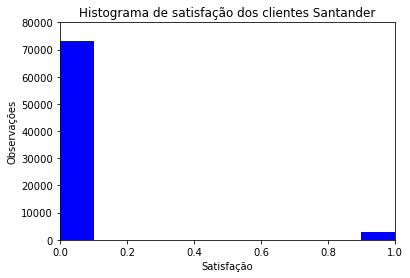

In [9]:
#Graficamente
plt.hist(df["TARGET"], facecolor='b', alpha=1)

plt.xlabel('Satisfação')
plt.ylabel('Observações')
plt.title('Histograma de satisfação dos clientes Santander')
plt.xlim(0, 1)
plt.ylim(0, 80000)
plt.grid(False)
plt.show()

O nível de satisfação é representado pelos valores numéricos 0 e 1, onde 0 representa os clientes satisfeitos e 1 os clientes insatisfeitos com os serviços do Santander.

In [10]:
X = df.iloc[:,0:271]
y = pd.DataFrame(df["TARGET"])

Iremos separar os dados entre treino e teste para assim balancearmos as classes alvo no dataset de treino através do SMOTE (Synthetic Minority Oversampling Technique) e evitarmos problemas posteriores.

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(X, y):
    X_treino, X_teste = X.loc[train_index], X.loc[test_index]
    y_treino, y_teste = y.loc[train_index], y.loc[test_index]

In [12]:
SMOTE_ = SMOTE(random_state=42)
X_treino_smt, y_treino_smt = SMOTE_.fit_resample(X_treino, y_treino)

## <center> <font color='blue'> TRABALHANDO A QUESTÃO DA DIMENSIONALIDADE

In [13]:
#Iremos utilizar um número de variáveis que explique 99% da variância de nosso dataset

pca_99 = PCA(n_components=0.99)
pca_treino_99 = pca_99.fit_transform(X_treino_smt)
exp_var_pca_99 = pca_99.explained_variance_ratio_
cum_sum_eigenvalues_99 = np.cumsum(exp_var_pca_99)

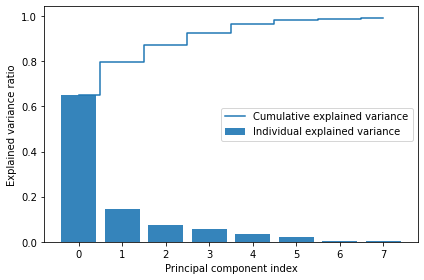

In [14]:
plt.bar(range(0,len(exp_var_pca_99)), exp_var_pca_99, alpha=0.9, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_99)), cum_sum_eigenvalues_99, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Como demonstrado no gráfico acima, uma redução de dimensionalidade de 270 para 6 nos permite explicar 95% da variância do dataset. Tais medidas nos ajuda a poupar poder computacional e gerar modelos mais "enxutos". 

In [15]:
X_treino = pd.DataFrame(pca_treino_99)

## <center> <font color='blue'> TREINANDO OS MODELOS BASE

In [17]:
random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
random_forest.fit(X_treino, np.ravel(y_treino_smt))

RandomForestClassifier(n_jobs=-1, random_state=42)

In [21]:
y_pred = cross_val_predict(random_forest, X_treino, np.ravel(y_treino_smt))

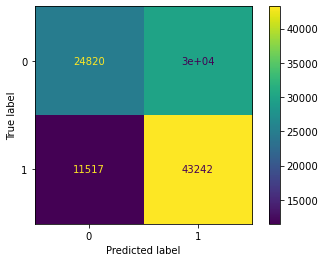

In [22]:
plot_confusion_matrix(random_forest, X_treino, y_treino_smt)

In [23]:
print(classification_report(y_treino_smt, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.45      0.54     54759
           1       0.59      0.78      0.67     54759

    accuracy                           0.61    109518
   macro avg       0.63      0.61      0.60    109518
weighted avg       0.63      0.61      0.60    109518

